---
title: "Curriculum Learning 🤝 DSPy: Data Exploration"
author: Shubham Gupta
date: '2025-08-31'
image: cl_dspy/curriculum_learning_data.png
description: Mapping ConvFinQA and crafting a curriculum for financial QA
lightbox: true
toc: true
footnotes-hover: false
format:
  html:
    highlight-style: gruvbox
    code-overflow: wrap
    code-fold: show
    code-tools: true
categories:
- programming
- dspy
---


While interviewing for my next role, I received a take-home assignment focused on financial reasoning over conversational data. Given all the hype around DSPy, I decided to use this opportunity to finally learn the tool properly.

Financial reasoning over conversational data presents a unique challenge in NLP: models must not only understand natural language but also perform multi-step numerical computations while maintaining context across dialogue turns.

[ConvFinQA](https://github.com/czyssrs/ConvFinQA) tackles this problem by combining conversational QA with financial documents and tables, requiring systems to execute chains of mathematical operations to arrive at correct answers.

What if we could improve model performance by teaching systems to learn from easier examples first, gradually building up to complex multi-turn reasoning? This is the core idea behind [curriculum learning](https://huggingface.co/learn/deep-rl-course/en/unitbonus3/curriculum-learning).

This post begins a series exploring curriculum learning with [DSPy](https://github.com/stanfordnlp/dspy). We start with an exploratory analysis of ConvFinQA to understand what makes some examples harder than others, identify complexity patterns in the data, and establish the foundation for a curriculum-based approach.

# Introduction

In [ ]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = json.load(open("../data/convfinqa_dataset.json"))
data.keys()

dict_keys(['train', 'dev'])

The current dataset only contains the `train` and `dev` splits.
For evaluation, we will likely use the `dev` split, and for training, we'll split the `train` split into a `train` and `val` split.

In [5]:
train_df = pd.DataFrame(data["train"])
test_df = pd.DataFrame(data["dev"])

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3037 entries, 0 to 3036
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3037 non-null   object
 1   doc       3037 non-null   object
 2   dialogue  3037 non-null   object
 3   features  3037 non-null   object
dtypes: object(4)
memory usage: 95.0+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        421 non-null    object
 1   doc       421 non-null    object
 2   dialogue  421 non-null    object
 3   features  421 non-null    object
dtypes: object(4)
memory usage: 13.3+ KB


We will _explode_ the columns with nested features to make them easier to work with.


In [10]:
train_flat_df = pd.concat(
    [
        train_df.drop(["doc", "dialogue", "features"], axis=1),
        train_df["doc"].apply(pd.Series).add_prefix("doc_"),
        train_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        train_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

test_flat_df = pd.concat(
    [
        test_df.drop(["doc", "dialogue", "features"], axis=1),
        test_df["doc"].apply(pd.Series).add_prefix("doc_"),
        test_df["dialogue"].apply(pd.Series).add_prefix("dialogue_"),
        test_df["features"].apply(pd.Series).add_prefix("features_"),
    ],
    axis=1,
)

In [11]:
train_flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3037 entries, 0 to 3036
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               3037 non-null   object
 1   doc_pre_text                     3037 non-null   object
 2   doc_post_text                    3037 non-null   object
 3   doc_table                        3037 non-null   object
 4   dialogue_conv_questions          3037 non-null   object
 5   dialogue_conv_answers            3037 non-null   object
 6   dialogue_turn_program            3037 non-null   object
 7   dialogue_executed_answers        3037 non-null   object
 8   dialogue_qa_split                3037 non-null   object
 9   features_num_dialogue_turns      3037 non-null   int64 
 10  features_has_type2_question      3037 non-null   bool  
 11  features_has_duplicate_columns   3037 non-null   bool  
 12  features_has_non_numeric_values  3

In [12]:
test_flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               421 non-null    object
 1   doc_pre_text                     421 non-null    object
 2   doc_post_text                    421 non-null    object
 3   doc_table                        421 non-null    object
 4   dialogue_conv_questions          421 non-null    object
 5   dialogue_conv_answers            421 non-null    object
 6   dialogue_turn_program            421 non-null    object
 7   dialogue_executed_answers        421 non-null    object
 8   dialogue_qa_split                421 non-null    object
 9   features_num_dialogue_turns      421 non-null    int64 
 10  features_has_type2_question      421 non-null    bool  
 11  features_has_duplicate_columns   421 non-null    bool  
 12  features_has_non_numeric_values  421

# EDA

### Missing Data

First, let's check to see if there's any missing data in any field.

<Axes: >

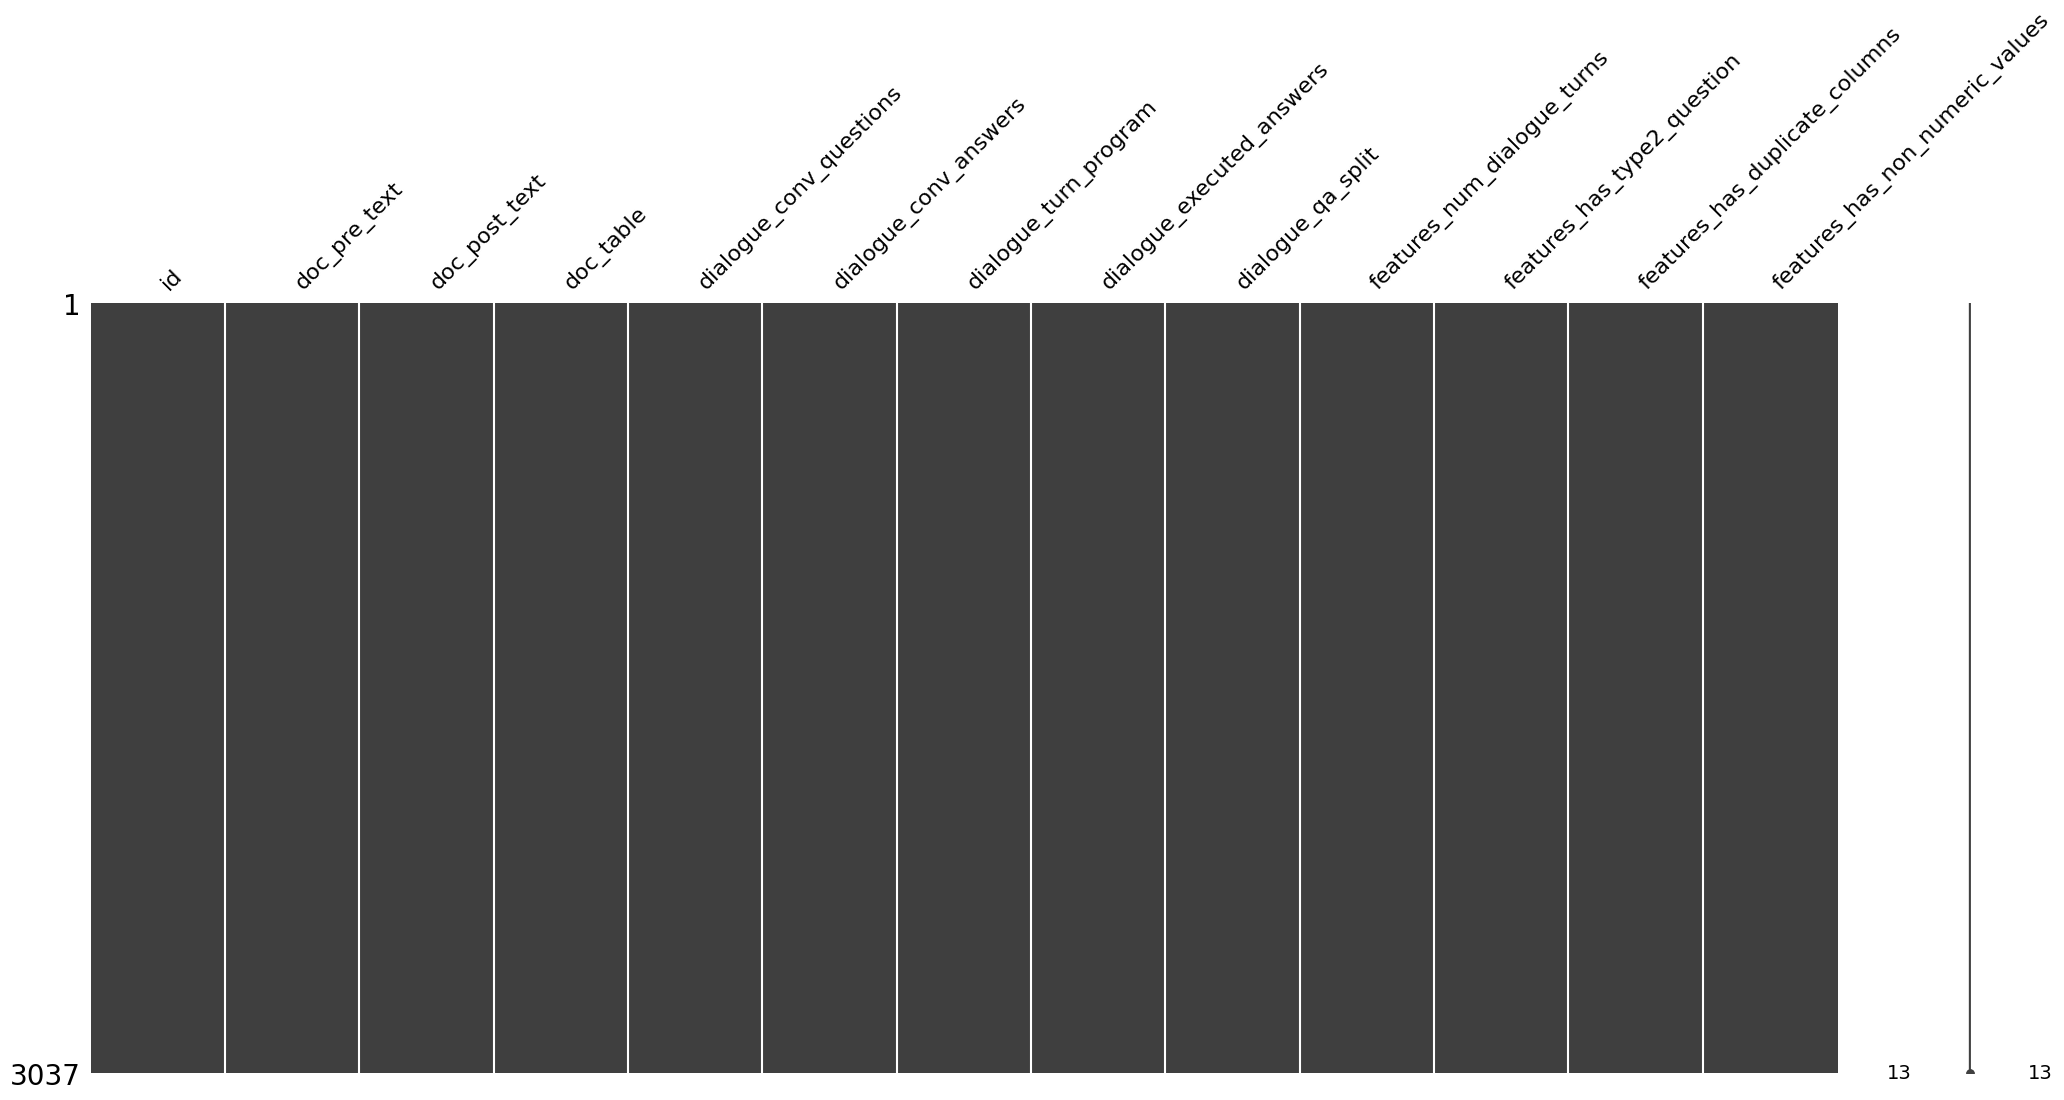

In [13]:
import missingno as msno

msno.matrix(train_flat_df)

<Axes: >

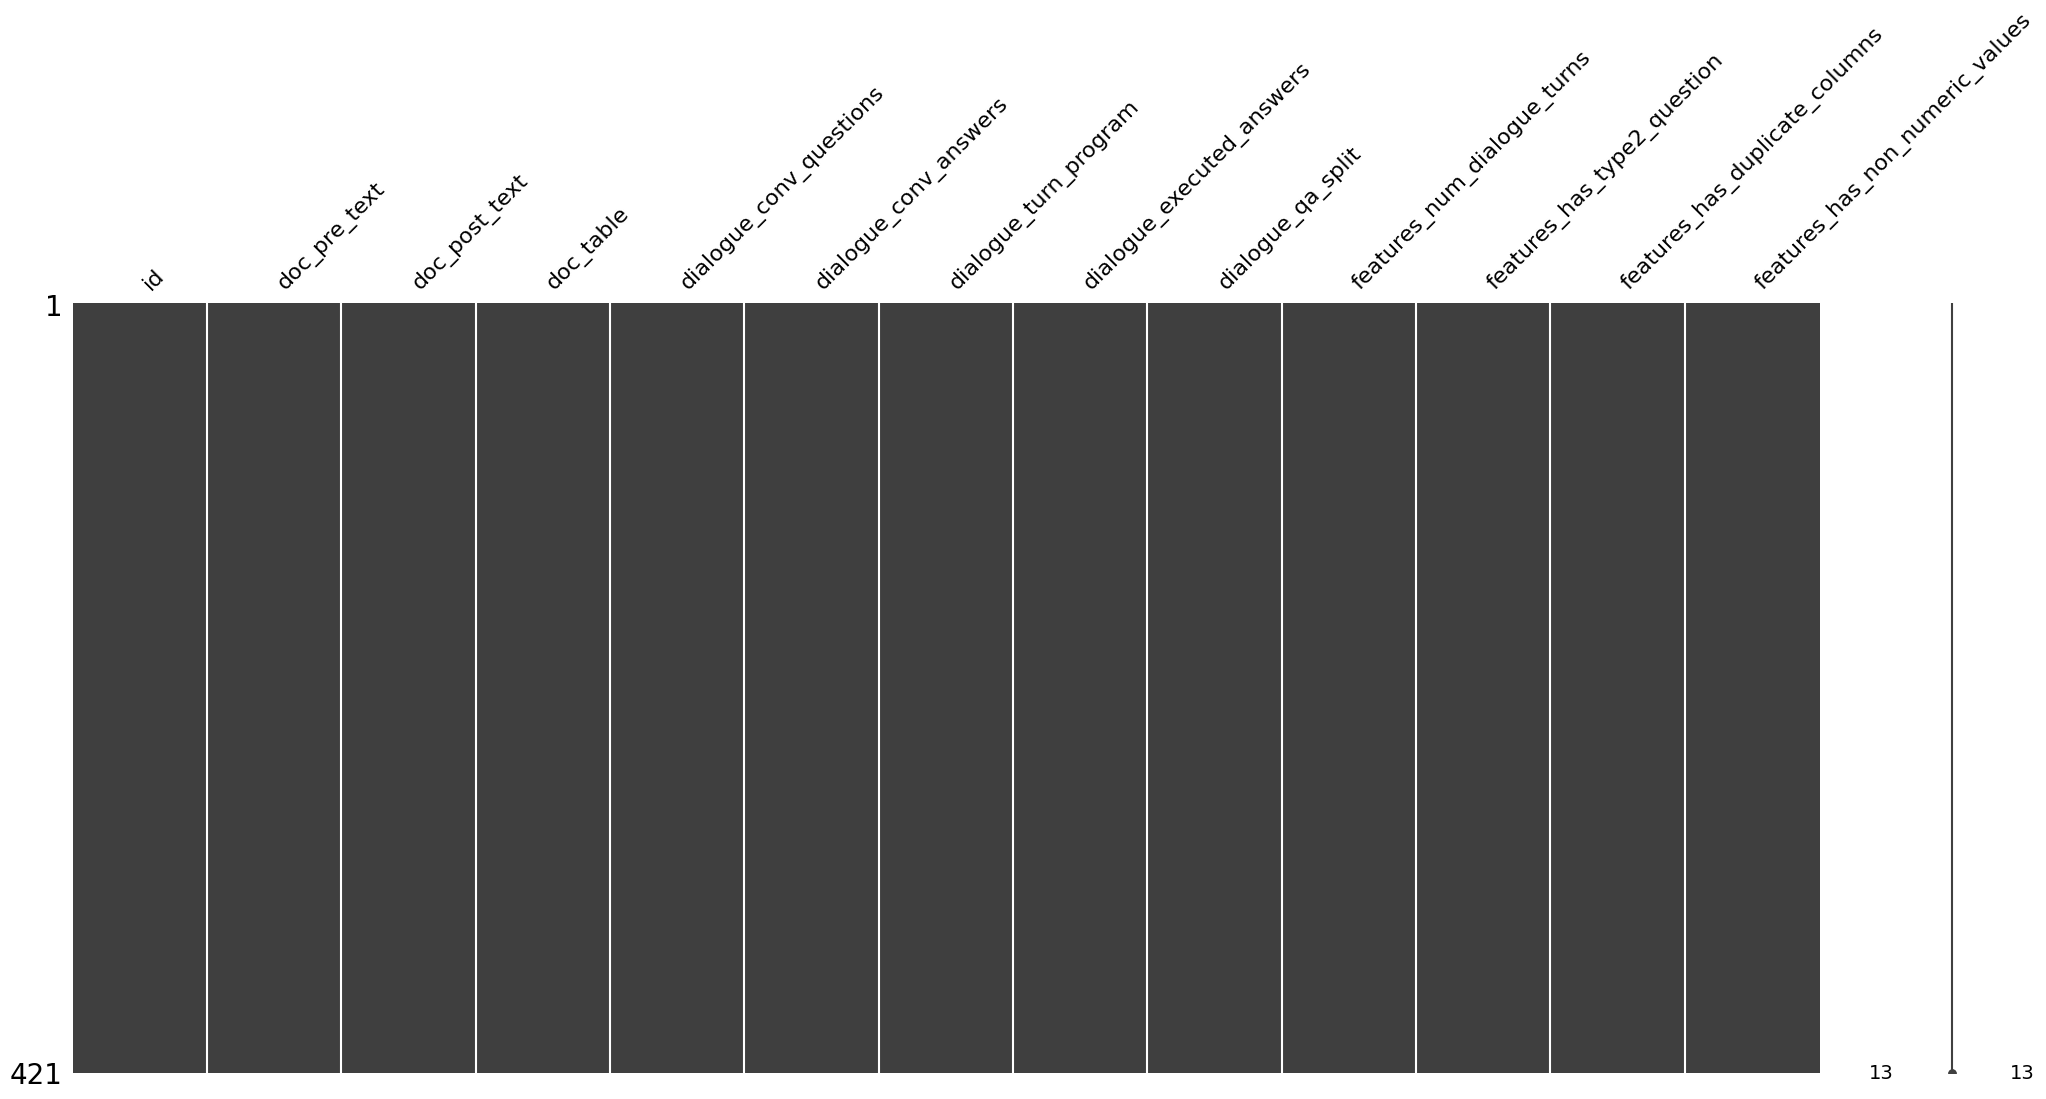

In [14]:
msno.matrix(test_flat_df)

No missing values in the training dataset.

## pre and post text

According to the database schema:

- pre_text -> Supporting text from the document occuring BEFORE the table content
- post_text -> Supporting text from the document occuring AFTER the table content


In [15]:
from pprint import pprint

pprint(train_flat_df["doc_pre_text"].head().iloc[0])

('26 | 2009 annual report in fiscal 2008 , revenues in the credit union '
 'systems and services business segment increased 14% ( 14 % ) from fiscal '
 '2007 . all revenue components within the segment experienced growth during '
 'fiscal 2008 . license revenue generated the largest dollar growth in revenue '
 'as episys ae , our flagship core processing system aimed at larger credit '
 'unions , experienced strong sales throughout the year . support and service '
 'revenue , which is the largest component of total revenues for the credit '
 'union segment , experienced 34 percent growth in eft support and 10 percent '
 'growth in in-house support . gross profit in this business segment increased '
 '$ 9344 in fiscal 2008 compared to fiscal 2007 , due primarily to the '
 'increase in license revenue , which carries the highest margins . liquidity '
 'and capital resources we have historically generated positive cash flow from '
 'operations and have generally used funds generated from 

In [16]:
train_flat_df["doc_pre_text"].apply(len).describe()

count    3037.000000
mean     1760.501811
std      1397.695620
min         1.000000
25%       568.000000
50%      1417.000000
75%      2765.000000
max      7153.000000
Name: doc_pre_text, dtype: float64

In [18]:
test_flat_df["doc_pre_text"].apply(len).describe()

count     421.000000
mean     1538.061758
std      1337.167597
min        17.000000
25%       410.000000
50%      1072.000000
75%      2347.000000
max      5639.000000
Name: doc_pre_text, dtype: float64

Looks like the pre_text in the data has some si

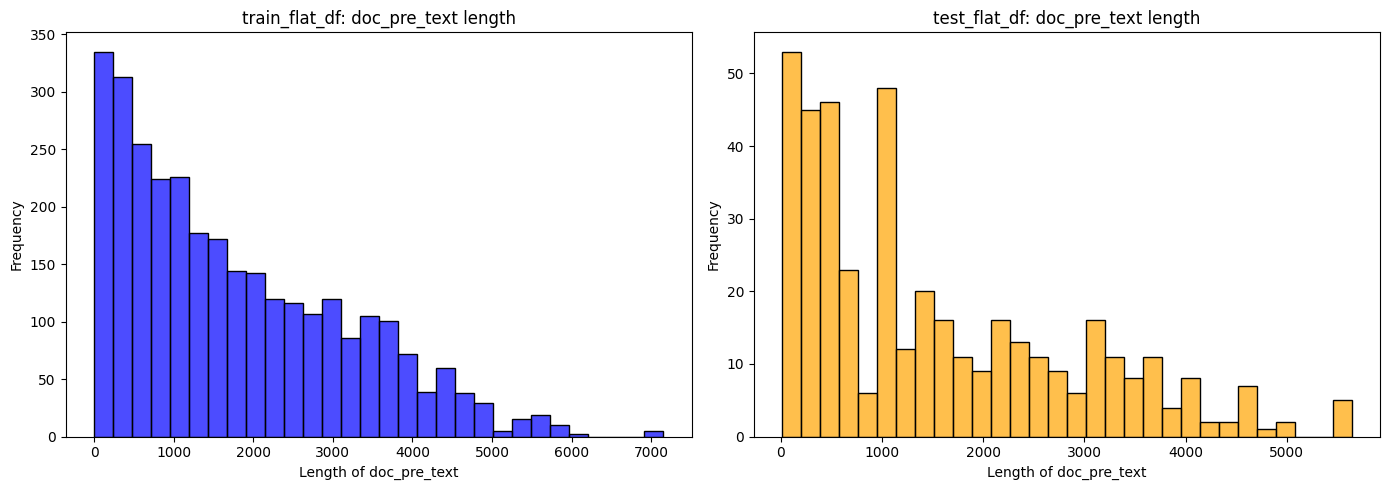

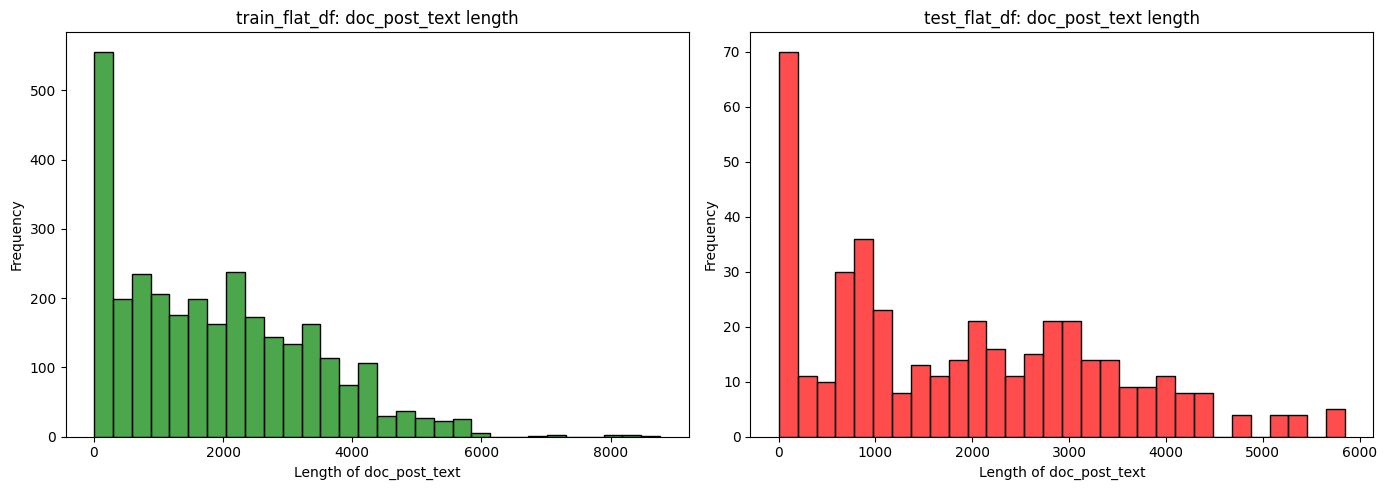

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(
    train_flat_df["doc_pre_text"].map(lambda x: len(str(x))),
    bins=30,
    color="blue",
    alpha=0.7,
    ax=axes[0],
)
axes[0].set_xlabel("Length of doc_pre_text")
axes[0].set_ylabel("Frequency")
axes[0].set_title("train_flat_df: doc_pre_text length")

sns.histplot(
    test_flat_df["doc_pre_text"].map(lambda x: len(str(x))),
    bins=30,
    color="orange",
    alpha=0.7,
    ax=axes[1],
)
axes[1].set_xlabel("Length of doc_pre_text")
axes[1].set_ylabel("Frequency")
axes[1].set_title("test_flat_df: doc_pre_text length")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(
    train_flat_df["doc_post_text"].map(lambda x: len(str(x))),
    bins=30,
    color="green",
    alpha=0.7,
    ax=axes[0],
)
axes[0].set_xlabel("Length of doc_post_text")
axes[0].set_ylabel("Frequency")
axes[0].set_title("train_flat_df: doc_post_text length")

sns.histplot(
    test_flat_df["doc_post_text"].map(lambda x: len(str(x))),
    bins=30,
    color="red",
    alpha=0.7,
    ax=axes[1],
)
axes[1].set_xlabel("Length of doc_post_text")
axes[1].set_ylabel("Frequency")
axes[1].set_title("test_flat_df: doc_post_text length")
plt.tight_layout()
plt.show()


Looks like the train and test data have a similar distribution for doc_pre_text and doc_post_text.

However, we do see some extreme outliers, with the large documents have > 5000 characters.

Most new generation LLMs do have a ctx window large enough to handle both pre text + table  + post text in the same context window, and we may not need any pre-processing for fields. However, we will revisit this later.

## `doc_table`

### Table Dimensions

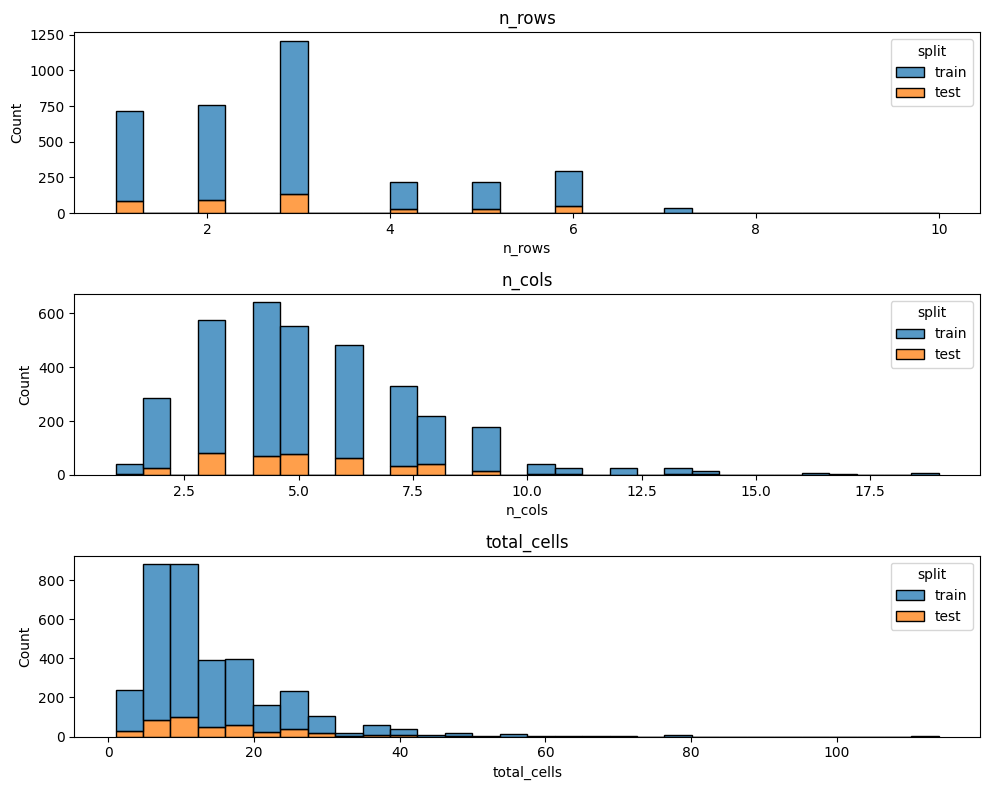

In [20]:
def compute_dims(table):
    """
    Compute basic shape statistics for a table dict.

    Args:
        table (dict): Mapping from row keys to dicts of column:value pairs.

    Returns:
        pd.Series: Series with n_rows, n_cols, total_cells.
            - n_rows: Number of rows in the table (outer dict keys)
            - n_cols: Number of unique columns across all rows
            - total_cells: Total number of (row, col) value pairs
    """
    n_rows = len(table)
    cols = {col for row in table.values() for col in row}
    n_cols = len(cols)
    total_cells = sum(len(row) for row in table.values())
    return pd.Series({"n_rows": n_rows, "n_cols": n_cols, "total_cells": total_cells})


for df in (train_flat_df, test_flat_df):
    df[["n_rows", "n_cols", "total_cells"]] = df["doc_table"].apply(compute_dims)


all_dims = pd.concat(
    [
        train_flat_df[["n_rows", "n_cols", "total_cells"]].assign(split="train"),
        test_flat_df[["n_rows", "n_cols", "total_cells"]].assign(split="test"),
    ],
    ignore_index=True,
)

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
for ax, col in zip(axes, ["n_rows", "n_cols", "total_cells"]):
    sns.histplot(data=all_dims, x=col, hue="split", multiple="stack", bins=30, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


Some key points:

- Most tables don't have more than 6 rows. This is good, since it limits the amount of error that can be introduced by the model when answering a question.
- Column distribution is a bit more extreme, especially in the training dataset.
  - While the training dataset has a maximum of 17 columns, most of the `test` dataset tops out at ~8-9 columns.
  - This is a good feature we could use to determine which records to use for the evaluation. More on this soon!
- Same as the number of columns, we see that the training dataset has a much wider distribution of number of cells. In the test set, the majority of records have cells < 30.

In [21]:
threshold = 10
print(f"Tables with more than {threshold} columns per split:")
for split, df in [("train", train_flat_df), ("test", test_flat_df)]:
    subset = df[df["n_cols"] > threshold]
    print(f"  {split}: {len(subset)}")
    if not subset.empty:
        print(subset[["id", "n_rows", "n_cols"]].head(), "\n")

Tables with more than 10 columns per split:
  train: 100
                                id  n_rows  n_cols
16     Double_PNC/2014/page_99.pdf       2      14
37    Single_GS/2013/page_47.pdf-2       3      12
90   Single_CDW/2015/page_34.pdf-2       5      12
133   Single_CE/2014/page_90.pdf-1       1      11
137   Single_C/2009/page_195.pdf-2       3      14 

  test: 8
                                id  n_rows  n_cols
50   Single_JPM/2007/page_33.pdf-2       3      11
51   Single_GS/2017/page_143.pdf-2       2      13
109  Single_JPM/2007/page_33.pdf-1       3      11
117  Single_GS/2017/page_143.pdf-1       2      13
298  Single_MA/2008/page_126.pdf-1       1      14 



In [22]:
def count_nested_tables(table):
    """
    Recursively count nested tables in a table dict.
    A nested table is any dict or list of dicts within cell values (deeper than the row level).
    """

    def _count(t, depth):
        cnt = 0
        if isinstance(t, dict):
            for v in t.values():
                if isinstance(v, dict):
                    if depth > 0:
                        cnt += 1
                    cnt += _count(v, depth + 1)
                elif isinstance(v, list):
                    for item in v:
                        if isinstance(item, dict):
                            if depth > 0:
                                cnt += 1
                            cnt += _count(item, depth + 1)
        return cnt

    return _count(table, 0)


for df in (train_flat_df, test_flat_df):
    df["nested_tables"] = df["doc_table"].apply(count_nested_tables)

print("Nested tables per split:")
for split, df in [("train", train_flat_df), ("test", test_flat_df)]:
    nt = df["nested_tables"]
    print(
        f"  {split}: docs w/ nested tables = {(nt > 0).sum()} / {len(nt)}, max nested = {nt.max()}"
    )

nested_df = pd.concat(
    [
        train_flat_df[["nested_tables"]].assign(split="train"),
        test_flat_df[["nested_tables"]].assign(split="test"),
    ],
    ignore_index=True,
)

nested_df.info()


Nested tables per split:
  train: docs w/ nested tables = 0 / 3037, max nested = 0
  test: docs w/ nested tables = 0 / 421, max nested = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   nested_tables  3458 non-null   int64 
 1   split          3458 non-null   object
dtypes: int64(1), object(1)
memory usage: 54.2+ KB


In [ ]:
nested_df[nested_df["nested_tables"] >= 2]

,nested_tables,split


Looks like the table are not deeply nested! This is good since we don't have to worry too much about table formatting, when sending the table as context to the LLM.

### Column Header Analysis

In [25]:
from collections import Counter


def analyze_split(df, split_name):
    n_docs = len(df)
    dup_count = df["features_has_duplicate_columns"].sum()
    years_per_doc = df["doc_table"].apply(len)
    year_stats = years_per_doc.describe().to_dict()

    freq = Counter()
    doc_freq = Counter()
    all_headers = set()
    for tbl in df["doc_table"]:
        hdrs_in_doc = set()
        for year_dict in tbl.values():
            freq.update(year_dict.keys())
            hdrs_in_doc.update(year_dict.keys())
        doc_freq.update(hdrs_in_doc)
        all_headers.update(hdrs_in_doc)

    print(f"\n--- {split_name.upper()} SPLIT ---")
    print(f"Total docs: {n_docs}")
    print(f"Docs w/ duplicate cols: {dup_count} ({dup_count / n_docs:.1%})")
    print(f"Years/doc stats: {year_stats}")
    print(f"Unique headers across all docs: {len(all_headers)}")
    print("Top 10 headers by total occurrences:", freq.most_common(10))
    print("Top 10 headers by docs appeared in:", doc_freq.most_common(10))


for name, df in [("train", train_flat_df), ("test", test_flat_df)]:
    analyze_split(df, name)


--- TRAIN SPLIT ---
Total docs: 3037
Docs w/ duplicate cols: 60 (2.0%)
Years/doc stats: {'count': 3037.0, 'mean': 2.839973658215344, 'std': 1.5134690841267935, 'min': 1.0, '25%': 2.0, '50%': 3.0, '75%': 3.0, 'max': 10.0}
Unique headers across all docs: 3948
Top 10 headers by total occurrences: [('total', 1147), ('s&p 500 index', 456), ('s&p 500', 419), ('other', 371), ('operating profit', 253), ('net sales', 229), ('2009', 210), ('2012', 206), ('2010', 206), ('2011', 201)]
Top 10 headers by docs appeared in: [('total', 383), ('other', 205), ('thereafter', 109), ('2012', 107), ('2011', 103), ('2013', 102), ('2010', 99), ('2009', 98), ('2014', 91), ('2018', 87)]

--- TEST SPLIT ---
Total docs: 421
Docs w/ duplicate cols: 17 (4.0%)
Years/doc stats: {'count': 421.0, 'mean': 3.0332541567695963, 'std': 1.6500609236986385, 'min': 1.0, '25%': 2.0, '50%': 3.0, '75%': 4.0, 'max': 8.0}
Unique headers across all docs: 833
Top 10 headers by total occurrences: [('total', 183), ('s&p 500 index', 120

### Row Header Analysis

In [26]:
from collections import Counter
import re


def normalize_row_key(k: str) -> str:
    """Lower-case, drop punctuation, collapse spaces."""
    if not k:
        return ""
    k = k.lower()
    k = re.sub(r"[_\-]", " ", k)
    k = re.sub(r"[()%:$,]", " ", k)
    return re.sub(r"\s+", " ", k).strip()


def analyze_row_headers(df, split_name: str, top_n: int = 10):
    raw_freq, norm_freq, summary_freq = Counter(), Counter(), Counter()
    summary_kw = (
        "total",
        "net",
        "%",
        "percent",
        "change",
        "difference",
        "subtotal",
        "summary",
    )

    for tbl in df["doc_table"]:
        if not isinstance(tbl, dict):
            continue
        for year_dict in tbl.values():
            if not isinstance(year_dict, dict):
                continue
            for raw in year_dict.keys():
                if raw is None:
                    continue
                raw = str(raw).strip()
                norm = normalize_row_key(raw)

                raw_freq[raw] += 1
                norm_freq[norm] += 1
                if any(k in raw.lower() for k in summary_kw):
                    summary_freq[raw] += 1

    total_rows = sum(raw_freq.values())
    print(f"\n===== {split_name.upper()} SPLIT : ROW HEADER ANALYSIS =====")
    print(f"Row instances              : {total_rows}")
    print(f"Unique raw headers         : {len(raw_freq):,}")
    print(f"Unique normalized headers  : {len(norm_freq):,}")

    print("\nRaw header  ➜  Normalized header (top 10 by freq)")
    for hdr, _ in raw_freq.most_common(10):
        print(f"{hdr[:55]:55} ➜ {normalize_row_key(hdr)}")

    print(f"\nTop-{top_n} most frequent financial metrics (normalized)")
    for hdr, cnt in norm_freq.most_common(top_n):
        print(f"{hdr[:55]:55} {cnt:>6}")

    tot_summary = sum(summary_freq.values())
    print(f"\nSubtotal/Summary rows detected (keywords {summary_kw})")
    print(f"Instances: {tot_summary}  ({tot_summary / total_rows:.1%} of all rows)")
    for hdr, cnt in summary_freq.most_common(10):
        print(f"{hdr[:55]:55} {cnt:>6}")


for name, df in (("train", train_flat_df), ("test", test_flat_df)):
    analyze_row_headers(df, name)



===== TRAIN SPLIT : ROW HEADER ANALYSIS =====
Row instances              : 42813
Unique raw headers         : 3,948
Unique normalized headers  : 3,921

Raw header  ➜  Normalized header (top 10 by freq)
total                                                   ➜ total
s&p 500 index                                           ➜ s&p 500 index
s&p 500                                                 ➜ s&p 500
other                                                   ➜ other
operating profit                                        ➜ operating profit
net sales                                               ➜ net sales
2009                                                    ➜ 2009
2012                                                    ➜ 2012
2010                                                    ➜ 2010
2011                                                    ➜ 2011

Top-10 most frequent financial metrics (normalized)
total                                                     1147
s&p 500 index       

We see some similar patterns in the row headers across the splits, but nothing of significance.

In [27]:
from collections import Counter
import re


def _yield_cells(x):
    if isinstance(x, dict):
        for v in x.values():
            yield from _yield_cells(v)
    elif isinstance(x, (list, tuple)):
        for v in x:
            yield from _yield_cells(v)
    else:
        yield x


def _parse_num(tok):
    s = str(tok).strip()
    if not s or s.lower() in ("na", "n/a", "nan", "-"):
        return None
    neg = (s.startswith("(") and s.endswith(")")) or s.endswith("-")
    s = s.strip("()").rstrip("-")
    s = re.sub(r"[,\$%]", "", s)
    mult = 1
    if s.lower().endswith("m"):
        mult, s = 1e6, s[:-1]
    elif s.lower().endswith("k"):
        mult, s = 1e3, s[:-1]
    try:
        val = float(s) * mult
        return -val if neg else val
    except:
        return None


def analyze_cell_values(df, split_name, top_n=10):
    total = num = missing = unp = 0
    unpatt = Counter()
    for tbl in df["doc_table"]:
        if not isinstance(tbl, dict):
            continue
        for cell in _yield_cells(tbl):
            total += 1
            txt = str(cell).strip()
            if cell is None or txt == "":
                missing += 1
            elif _parse_num(cell) is None:
                unp += 1
                key = txt.lower()[:25]
                unpatt[key] += 1
            else:
                num += 1

    print(f"\n=== {split_name.upper()} CELL QUALITY ===")
    print(f"total: {total}, numeric: {num}, missing: {missing}, unparseable: {unp}")
    print(f"Top {top_n} unparseable patterns:")
    for pat, cnt in unpatt.most_common(top_n):
        print(f"  {pat:25} {cnt}")


for name, d in (("train", train_flat_df), ("test", test_flat_df)):
    analyze_cell_values(d, name)



=== TRAIN CELL QUALITY ===
total: 42813, numeric: 41499, missing: 184, unparseable: 1130
Top 10 unparseable patterns:
  -                         265
  n/a                       147
  ( in thousands )          102
  nm                        62
  owned                     43
  $ -                       42
  pay                       22
  fta                       20
  cash                      16
  leased                    14

=== TEST CELL QUALITY ===
total: 6159, numeric: 6045, missing: 12, unparseable: 102
Top 10 unparseable patterns:
  -                         13
  none                      9
  high                      6
  low                       6
  ( b )                     6
  leased                    6
  united states             4
  united kingdom            4
  ( d )                     3
  nm                        3


We see that:

- **Train** (42,813 total cells): 97.0% numeric, 0.4% missing, 2.6% unparseable  
- **Test** (6,159 total cells): 98.2% numeric, 0.2% missing, 1.7% unparseable  

Top unparseable patterns include `-`, `n/a`, `( in thousands )`, `nm`, `none`, `high`, `low`, etc., indicating placeholders, qualifiers, and unit headers that need cleaning or custom parsing.

When selecting records for evaluation, we should:

- Exclude or preprocess records with unparseable cells (~1,232 cells total).  
- Drop tables where >5% of cells are unparseable to ensure numeric consistency.

This keeps our evaluation set focused on clean, numeric data and avoids noise from poorly parsed entries. More on this later!


In [28]:
train_flat_df.columns

Index(['id', 'doc_pre_text', 'doc_post_text', 'doc_table',
       'dialogue_conv_questions', 'dialogue_conv_answers',
       'dialogue_turn_program', 'dialogue_executed_answers',
       'dialogue_qa_split', 'features_num_dialogue_turns',
       'features_has_type2_question', 'features_has_duplicate_columns',
       'features_has_non_numeric_values', 'n_rows', 'n_cols', 'total_cells',
       'nested_tables'],
      dtype='object')

## `dialogue_conv_questions`

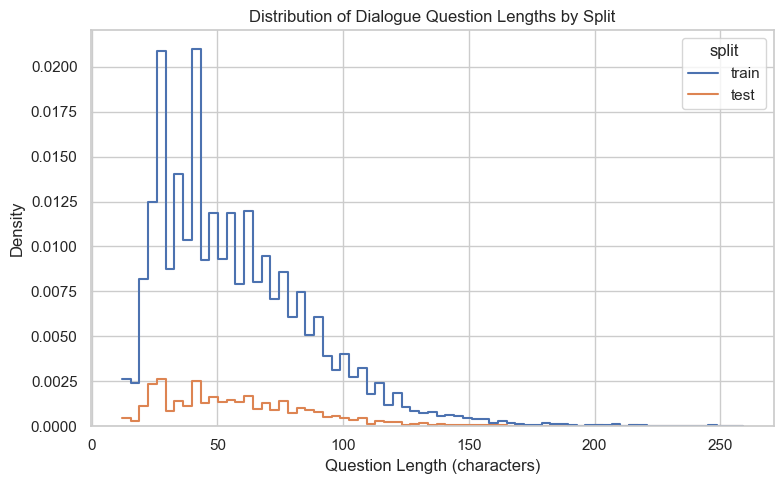

In [29]:
train_q_lens = train_flat_df["dialogue_conv_questions"].explode().dropna().map(len)
test_q_lens = test_flat_df["dialogue_conv_questions"].explode().dropna().map(len)
df_q = pd.concat(
    [
        pd.DataFrame({"length": train_q_lens, "split": "train"}),
        pd.DataFrame({"length": test_q_lens, "split": "test"}),
    ]
)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_q, x="length", hue="split", stat="density", element="step", fill=False
)
plt.title("Distribution of Dialogue Question Lengths by Split")
plt.xlabel("Question Length (characters)")
plt.ylabel("Density")
plt.tight_layout()


Majority of the questions in both the train and test set are short. This is ideal.

## `dialogue_conv_answers`

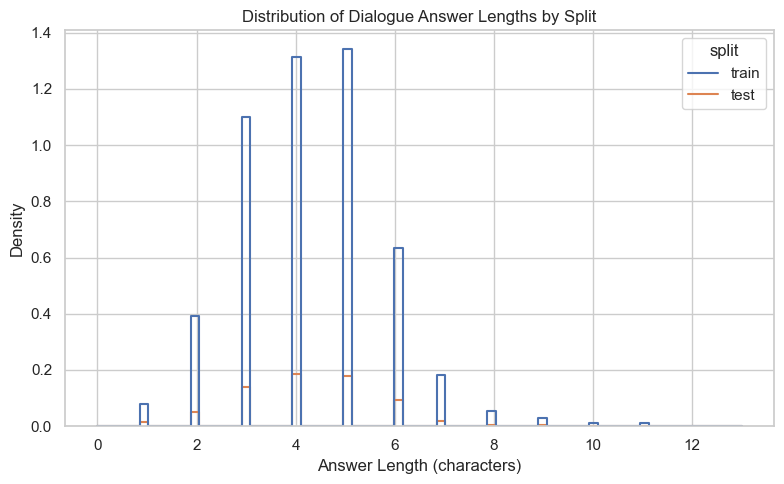

In [30]:
train_q_lens = train_flat_df["dialogue_conv_answers"].explode().dropna().map(len)
test_q_lens = test_flat_df["dialogue_conv_answers"].explode().dropna().map(len)
df_q = pd.concat(
    [
        pd.DataFrame({"length": train_q_lens, "split": "train"}),
        pd.DataFrame({"length": test_q_lens, "split": "test"}),
    ]
)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_q, x="length", hue="split", stat="density", element="step", fill=False
)
plt.title("Distribution of Dialogue Answer Lengths by Split")
plt.xlabel("Answer Length (characters)")
plt.ylabel("Density")
plt.tight_layout()


As mentioned in the dataset, most of the answers are either numeric or boolean in nature. We see a majority of the answers having length <= 8, meaning that these are either large numbers, or numbers with large precision.

## `dialogue_turn_program`

This field represents the program DSL generated for the current turn.

In [31]:
train_flat_df["dialogue_turn_program"].head()

0    [206588, 181001, subtract(206588, 181001), sub...
1    [9362.2, 9244.9, subtract(9362.2, 9244.9), sub...
2    [5363, 7983, subtract(5363, 7983), subtract(53...
3    [subtract(75.95, const_100), subtract(75.95, c...
4    [subtract(91.06, const_100), subtract(91.06, c...
Name: dialogue_turn_program, dtype: object

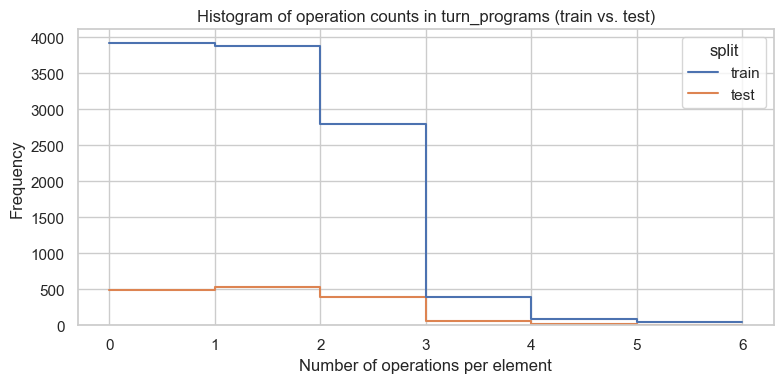

In [32]:
def _get_op_counts(df: pd.DataFrame) -> pd.Series:
    """Return a Series with the number of '(' in every element of dialogue_turn_program."""
    return (
        df["dialogue_turn_program"]
        .explode()  # one element per row
        .dropna()
        .apply(lambda rec: str(rec).count("("))
    )


counts_train = _get_op_counts(train_flat_df)
counts_test = _get_op_counts(test_flat_df)

df_counts = pd.concat(
    [
        pd.DataFrame({"ops": counts_train, "split": "train"}),
        pd.DataFrame({"ops": counts_test, "split": "test"}),
    ]
)

plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_counts,
    x="ops",
    hue="split",
    bins=range(0, df_counts["ops"].max() + 2),
    element="step",
    fill=False,
)
plt.xlabel("Number of operations per element")
plt.ylabel("Frequency")
plt.title("Histogram of operation counts in turn_programs (train vs. test)")
plt.tight_layout()
plt.show()


Similar distributions for number of operations in both the train and test set. Majority of the operations are < 4 .

We could argue that the number of operations is a good proxy for the complexity of the program. As such, we should probably aim to do well first on the examples where the number of operations is small.

In [33]:
train_flat_df.columns

Index(['id', 'doc_pre_text', 'doc_post_text', 'doc_table',
       'dialogue_conv_questions', 'dialogue_conv_answers',
       'dialogue_turn_program', 'dialogue_executed_answers',
       'dialogue_qa_split', 'features_num_dialogue_turns',
       'features_has_type2_question', 'features_has_duplicate_columns',
       'features_has_non_numeric_values', 'n_rows', 'n_cols', 'total_cells',
       'nested_tables'],
      dtype='object')

## `features_num_dialogue_turns`

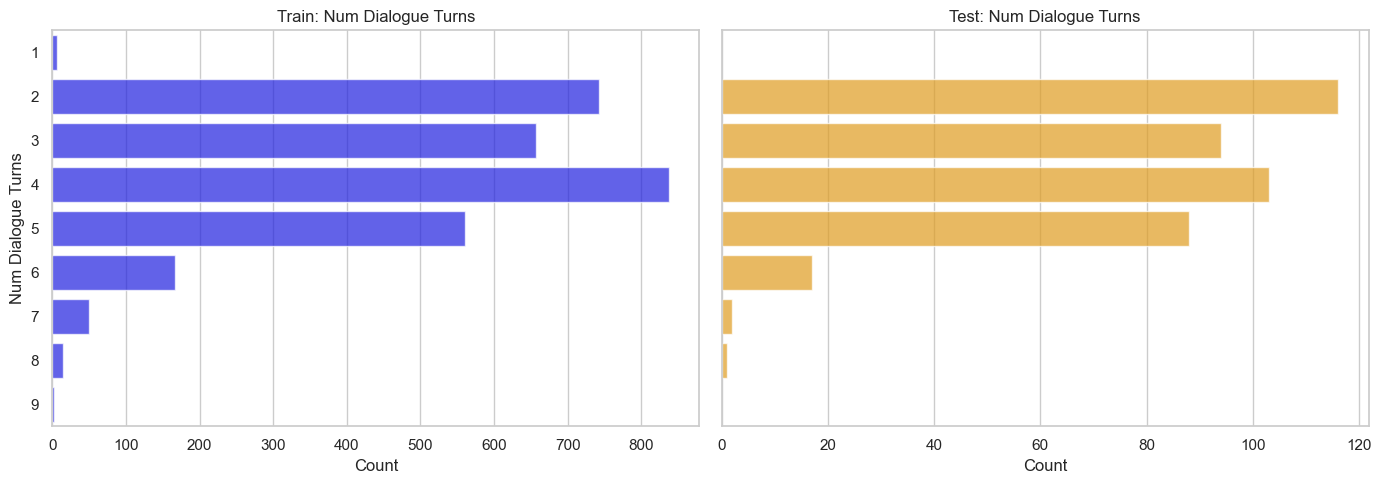

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

order = sorted(
    set(train_flat_df["features_num_dialogue_turns"]).union(
        test_flat_df["features_num_dialogue_turns"]
    )
)

sns.countplot(
    y="features_num_dialogue_turns",
    data=train_flat_df,
    order=order,
    ax=axes[0],
    color="blue",
    alpha=0.7,
)
axes[0].set(
    title="Train: Num Dialogue Turns", xlabel="Count", ylabel="Num Dialogue Turns"
)

sns.countplot(
    y="features_num_dialogue_turns",
    data=test_flat_df,
    order=order,
    ax=axes[1],
    color="orange",
    alpha=0.7,
)
axes[1].set(title="Test: Num Dialogue Turns", xlabel="Count", ylabel="")

plt.tight_layout()
plt.show()


Similar distributions across the train and test sets. As mentioned in the paper, we should expect conversations with more dialogue turns, to be more difficult to answer for models.

This is yet another feature we could use when deciding how to split our data into train, validation, and test sets.


In [35]:
train_flat_df.columns

Index(['id', 'doc_pre_text', 'doc_post_text', 'doc_table',
       'dialogue_conv_questions', 'dialogue_conv_answers',
       'dialogue_turn_program', 'dialogue_executed_answers',
       'dialogue_qa_split', 'features_num_dialogue_turns',
       'features_has_type2_question', 'features_has_duplicate_columns',
       'features_has_non_numeric_values', 'n_rows', 'n_cols', 'total_cells',
       'nested_tables'],
      dtype='object')

## `features_has_type2_question`

Train set – Has Type 2 Question counts:
features_has_type2_question
False    2148
True      889
Name: count, dtype: int64

Test set – Has Type 2 Question counts:
features_has_type2_question
False    300
True     121
Name: count, dtype: int64



/var/folders/zf/l4rjbhhj6xq9bfzs9cr7m5vr0000gn/T/ipykernel_98862/668524099.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/zf/l4rjbhhj6xq9bfzs9cr7m5vr0000gn/T/ipykernel_98862/668524099.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


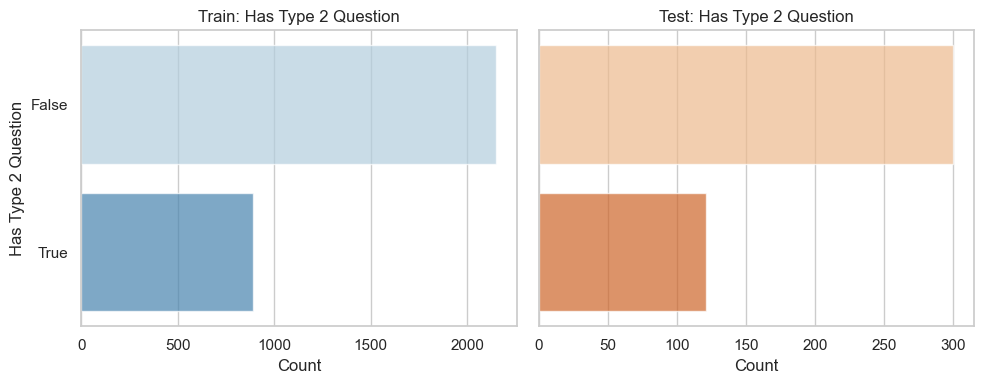

In [36]:
import seaborn as sns

for name, df in [("Train", train_flat_df), ("Test", test_flat_df)]:
    vc = df["features_has_type2_question"].value_counts()
    print(f"{name} set – Has Type 2 Question counts:\n{vc}\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(
    y="features_has_type2_question",
    data=train_flat_df,
    ax=axes[0],
    palette="Blues",
    alpha=0.7,
)
axes[0].set(
    title="Train: Has Type 2 Question", xlabel="Count", ylabel="Has Type 2 Question"
)

sns.countplot(
    y="features_has_type2_question",
    data=test_flat_df,
    ax=axes[1],
    palette="Oranges",
    alpha=0.7,
)
axes[1].set(title="Test: Has Type 2 Question", xlabel="Count", ylabel="")

plt.tight_layout()
plt.show()


Similar distrbutions for Type2 questions across the train and test sets, as expected.

# Methodology

<a id="methodology"></a>


Given the above dataset analysis, a few things are clear:

- Given the recent explosion of ctx window size for language models, we should be able to build strong baselines model without any finetuning.
- The length analysis of the different fields(pre/post text, table, questions, etc.) confirms that we will likely not need any form of retrieval to answer the questions, **contradictory** to the original paper.
- There are varying levels of difficulty in the given set of questions and answer.
  - We ideally should leverage this to build our models in stages, such that we can track and measure accuracy and perform error analysis at each stage.

The current generation of language models have 3 main phases of training:  

- **pre-training**: large-scale self-supervised next-token prediction on massive web corpora (e.g., C4, Common Crawl) to learn general language patterns.  
- **mid-training**: intermediate training on medium-sized, higher-quality or domain-specific data (10–300 B tokens) with curriculum learning, long-context adaptation, and synthetic/instructional examples to sharpen capabilities.  
- **post-training**: fine-tuning or instruction-tuning on smaller, curated datasets (100 M–1 B tokens) and often RLHF to align the model to downstream tasks and human preferences.  

As seen with our dataset, even current language models are **trained in stages**, with problems that are seemingly difficult for models to understand explicitly trained in either the mid or post-training phase.

This methodology has roots in an reinforcement learning technique called **Curriculum Learning**.

### Curriculum Learning

**Core Idea**: Curriculum learning for LLMs involves carefully selecting and ordering training data based on difficulty, starting with simpler examples and gradually introducing more complex ones. 

**Why it's beneficial:**

- Improved Efficiency:
  - By starting with easier examples, LLMs can learn fundamental concepts more effectively and then build upon that knowledge. 
- Better Generalization:
  - A well-designed curriculum can help LLMs generalize better to unseen data by exposing them to a wider range of complexities and nuances. 
- Reduced Training Time:
  - In some cases, curriculum learning can lead to faster convergence and reduced training time. 

<p align="center">
  <img src="./cl_dspy/curriculum_learning_data.png" width="400" height="500">
  <br>
  <sub>
    Source: <a href="https://arxiv.org/pdf/2101.10382">Curriculum Learning: A Survey</a>, Soviany et al.
  </sub>
</p>

For our dataset, given our analysis, we have the following levers to consider:

- Number of Turns buckets. Eg: 1–2, 3–4, 5–6, ≥7
- Number of max ops bucket: Eg: 0–1, 2–3, 4+
- Type1 vs Type2 questions
- Context length bucket (pre_text/post_text len): ≤P50, P50–P80, >P80
- Noise flags: duplicate columns / non-numeric values 

Given that we had limited time, we will pick the following 

- **Easy**
  - This is the Core stage
  - We hope the model will learn how to answer questions that directly pick answers from context, perform simple operations, and can carry previous answers minimally.
  - We will use the following filters(all must hold TRUE):
    - max_ops_per_conversation ≤ 2
    - 2 ≤ num_dialogue_turns ≤ 4
    - has_type2_question == False
    - doc_pre_text_len ≤ P50_pre
    - doc_post_text_len ≤ P50_post
    - total_cells ≤ P50_cells 

- **Medium**
  - This stage focuses on improving the reasoning ability of the model, and it's ability to track dependencies.
  - The hope is that this stage will help the model learn multi-op arithmetic, cross question dependencies, and variable reuse.
    - Filters (must satisfy both lines)
      - ( (max_ops_per_conversation ∈ {2,3}) OR (has_type2_question == True) )
      - 3 ≤ num_dialogue_turns ≤ 6 
      - doc_pre_text_len ≤ P90_pre 
      - doc_post_text_len ≤ P90_post 
      - total_cells ≤ P90_cells
    - This admits many max_ops=2 dialogs but with more turns and/or Type2. 
- **Hard**
  - This stage will aim to tackle the long-tail of difficult problems, and help introduce much needed robustness in our models.
  - Specifically, we hope that at the end of this stage, the model is good at long context answer, which requires retrieval and reasoning, extreme op depth, and poorly formatted/large tables.
  - Filters (any single trigger is enough)
    - Deep ops: max_ops_per_conversation ≥ 4 OR
    - Long dialogs: features_num_dialogue_turns ≥ 7
    - Long context: doc_pre_text_len > P90_pre OR doc_post_text_len > P90_post 
    - Large tables: total_cells > P90_cells 
    - Noisy schema: has_non_numeric_values OR has_duplicate_columns with some complexity → ~10–15%

> To prevent overlap and duplicates, we will construct the stages in reverse order i.e
>  - Hard first to ensure we isolate the difficult problems
>  - Easy next to identify baseline performance
>  - Remaining problems go into medium to help develop better reasoning and arithmetic abilities.

In [38]:
def get_max_ops_per_conversation(df):
    def max_ops(turn_programs):
        # turn_programs is a list of lists (or strings), one per turn
        # Each turn_program is a string or list of strings, e.g. ['subtract(206588, 181001)', ...]
        # We'll count the number of operations per turn, then take the max
        import re

        if not isinstance(turn_programs, list):
            return 0
        op_pattern = re.compile(r"([a-zA-Z_][a-zA-Z0-9_]*\()")
        max_ops = 0
        for turn in turn_programs:
            if isinstance(turn, str):
                # count ops in the string
                ops = len(op_pattern.findall(turn))
            elif isinstance(turn, list):
                # count ops in all strings in the list
                ops = sum(len(op_pattern.findall(str(x))) for x in turn)
            else:
                ops = 0
            if ops > max_ops:
                max_ops = ops
        return max_ops

    return df["dialogue_turn_program"].apply(max_ops)


train_flat_df["max_ops_per_conversation"] = get_max_ops_per_conversation(train_flat_df)
test_flat_df["max_ops_per_conversation"] = get_max_ops_per_conversation(test_flat_df)

In [40]:
train_flat_df["doc_pre_text_len"] = train_flat_df["doc_pre_text"].apply(
    lambda x: len(x.split())
)
train_flat_df["doc_post_text_len"] = train_flat_df["doc_post_text"].apply(
    lambda x: len(x.split())
)

test_flat_df["doc_pre_text_len"] = test_flat_df["doc_pre_text"].apply(
    lambda x: len(x.split())
)
test_flat_df["doc_post_text_len"] = test_flat_df["doc_post_text"].apply(
    lambda x: len(x.split())
)


In [41]:
train_flat_df[
    [
        "max_ops_per_conversation",
        "features_has_type2_question",
        "features_has_duplicate_columns",
        "features_num_dialogue_turns",
        "features_has_non_numeric_values",
        "doc_pre_text_len",
        "doc_post_text_len",
        "n_rows",
        "n_cols",
        "total_cells",
    ]
].astype(int).describe()


,max_ops_per_conversation,features_has_type2_question,features_has_duplicate_columns,features_num_dialogue_turns,features_has_non_numeric_values,doc_pre_text_len,doc_post_text_len,n_rows,n_cols,total_cells
count,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000
mean,2.035232,0.292723,0.019756,3.656240,0.122160,300.901218,320.378005,2.839974,5.232137,14.097135
std,0.655179,0.455087,0.139185,1.319899,0.327524,239.324988,256.003210,1.513469,2.506996,10.260609
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,3.000000,0.000000,100.000000,102.000000,2.000000,3.000000,7.000000
50%,2.000000,0.000000,0.000000,4.000000,0.000000,244.000000,285.000000,3.000000,5.000000,12.000000
75%,2.000000,1.000000,0.000000,5.000000,0.000000,470.000000,498.000000,3.000000,7.000000,18.000000
max,5.000000,1.000000,1.000000,9.000000,1.000000,1132.000000,1489.000000,10.000000,19.000000,114.000000


In [42]:
test_flat_df[
    [
        "max_ops_per_conversation",
        "features_has_type2_question",
        "features_has_duplicate_columns",
        "features_num_dialogue_turns",
        "features_has_non_numeric_values",
        "doc_pre_text_len",
        "doc_post_text_len",
        "n_rows",
        "n_cols",
        "total_cells",
    ]
].astype(int).describe()


,max_ops_per_conversation,features_has_type2_question,features_has_duplicate_columns,features_num_dialogue_turns,features_has_non_numeric_values,doc_pre_text_len,doc_post_text_len,n_rows,n_cols,total_cells
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,2.061758,0.287411,0.040380,3.539192,0.076010,263.475059,322.712589,3.033254,5.173397,14.629454
std,0.658993,0.453093,0.197083,1.252239,0.265329,226.086872,252.372826,1.650061,2.206237,8.670173
min,1.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,0.000000,0.000000,2.000000,0.000000,74.000000,119.000000,2.000000,3.000000,8.000000
50%,2.000000,0.000000,0.000000,4.000000,0.000000,187.000000,292.000000,3.000000,5.000000,12.000000
75%,2.000000,1.000000,0.000000,5.000000,0.000000,406.000000,520.000000,4.000000,6.000000,18.000000
max,5.000000,1.000000,1.000000,8.000000,1.000000,933.000000,1099.000000,8.000000,14.000000,48.000000


## Curriculum Design & Quota Rebalancing

While our complexity classification captures overall difficulty, curriculum learning requires more nuanced sampling strategies. Simply taking the hardest examples might create an imbalanced curriculum that overrepresents certain types of complexity while ignoring others.

Consider two scenarios:
1. **Naive sampling**: We randomly sample from our "Hard" bucket and end up with 80% long-context examples but only 5% multi-operation examples
2. **Quota sampling**: We ensure balanced representation across complexity dimensions

The second approach creates a more robust curriculum. Our hard examples should include:
- **Deep reasoning** (4+ mathematical operations)
- **Long conversations** (7+ dialogue turns)
- **Dense context** (lengthy pre/post text)
- **Complex tables** (many cells, nested structures)
- **Noisy data** (duplicate columns, non-numeric values)

This ensures our model learns to handle diverse types of complexity rather than overfitting to a single difficulty dimension. The following code implements quota-based sampling to achieve this balanced representation:

In [ ]:
from pprint import pprint
from pathlib import Path
import numpy as np

TARGETS = {
    "Easy": {"train": 300, "valid": 70, "test": 80},
    "Medium": {"train": 300, "valid": 70, "test": 80},
    "Hard": {"train": 220, "valid": 60, "test": 80},
}
OUTDIR = Path("splits")
RANDOM_STATE = 42

P50_pre = int(train_flat_df["doc_pre_text_len"].quantile(0.50))
P65_pre = int(train_flat_df["doc_pre_text_len"].quantile(0.65))
P80_pre = int(train_flat_df["doc_pre_text_len"].quantile(0.80))
P90_pre = int(train_flat_df["doc_pre_text_len"].quantile(0.90))

P50_post = int(train_flat_df["doc_post_text_len"].quantile(0.50))
P65_post = int(train_flat_df["doc_post_text_len"].quantile(0.65))
P80_post = int(train_flat_df["doc_post_text_len"].quantile(0.80))
P90_post = int(train_flat_df["doc_post_text_len"].quantile(0.90))

P50_cells = int(train_flat_df["total_cells"].quantile(0.50))
P65_cells = int(train_flat_df["total_cells"].quantile(0.65))
P80_cells = int(train_flat_df["total_cells"].quantile(0.80))
P90_cells = int(train_flat_df["total_cells"].quantile(0.90))

print(
    f"[Percentiles/train] pre P50={P50_pre}, P65={P65_pre}, P80={P80_pre}, P90={P90_pre} "
    f"| post P50={P50_post}, P65={P65_post}, P80={P80_post}, P90={P90_post} "
    f"| cells P50={P50_cells}, P65={P65_cells}, P80={P80_cells}, P90={P90_cells}"
)


def assign_stages(df: pd.DataFrame) -> pd.Series:
    mops = df["max_ops_per_conversation"]
    turns = df["features_num_dialogue_turns"]
    t2 = df["features_has_type2_question"]
    preL = df["doc_pre_text_len"]
    postL = df["doc_post_text_len"]
    cells = df["total_cells"]
    dup = df["features_has_duplicate_columns"]
    nonnum = df["features_has_non_numeric_values"]

    # HARD (tail)
    hard = (
        (mops >= 4)
        | (turns >= 7)
        | (preL > P90_pre)
        | (postL > P90_post)
        | (cells > P90_cells)
        | (dup)
        | (
            nonnum
            & (
                (mops >= 3)
                | (preL > P80_pre)
                | (postL > P80_post)
                | (cells > P80_cells)
            )
        )
    )

    # EASY (P65)
    easy = (~hard) & (
        (mops <= 2)
        & (turns.between(2, 4, inclusive="both"))
        & (~t2)
        & (preL <= P65_pre)
        & (postL <= P65_post)
        & (cells <= P65_cells)
    )

    # MEDIUM (middle band)
    medium = (
        (~hard)
        & (~easy)
        & (
            ((mops.isin([2, 3])) | (t2))
            & (turns.between(3, 6, inclusive="both"))
            & (preL <= P90_pre)
            & (postL <= P90_post)
            & (cells <= P90_cells)
        )
    )

    stage = pd.Series(index=df.index, dtype="string")
    stage.loc[hard] = "Hard"
    stage.loc[easy] = "Easy"
    stage.loc[medium] = "Medium"
    stage = stage.fillna("Medium")
    return stage


cur_train_df = train_flat_df.copy()
cur_test_df = test_flat_df.copy()
cur_train_df["stage"] = assign_stages(cur_train_df)
cur_test_df["stage"] = assign_stages(cur_test_df)

print("[Stage counts] TRAIN:", cur_train_df["stage"].value_counts().to_dict())
print("[Stage counts] TEST:  ", cur_test_df["stage"].value_counts().to_dict())


def sample_df(df: pd.DataFrame, n: int, seed: int) -> pd.DataFrame:
    if n <= 0 or df.empty:
        return df.iloc[0:0]
    if len(df) <= n:
        return df.sample(frac=1.0, random_state=seed)  # shuffle full pool if small
    return df.sample(n=n, random_state=seed)


# =========================
# HARD QUOTA REBALANCING
# =========================

HARD_PROPS = {
    "deep_ops": 0.23,  # max_ops >= 4
    "long_turns": 0.23,  # turns >= 7
    "long_ctx": 0.27,  # pre > P90_pre OR post > P90_post
    "big_table": 0.20,  # total_cells > P90_cells
    "noisy": 0.07,  # duplicate OR non-numeric (with complexity already in stage)
}


def hard_bucket_masks(df: pd.DataFrame):
    return {
        "deep_ops": (df["max_ops_per_conversation"] >= 4),
        "long_turns": (df["features_num_dialogue_turns"] >= 7),
        "long_ctx": (df["doc_pre_text_len"] > P90_pre)
        | (df["doc_post_text_len"] > P90_post),
        "big_table": (df["total_cells"] > P90_cells),
        "noisy": (df["features_has_duplicate_columns"])
        | (df["features_has_non_numeric_values"]),
    }


def quota_sample_df(
    pool: pd.DataFrame, total_n: int, masks: dict, props: dict, seed: int
) -> pd.DataFrame:
    """
    Quota-based sampling without replacement across overlapping buckets.
    - masks: dict[name] -> boolean Series over pool
    - props: dict[name] -> proportion (0..1)
    Strategy:
      1) compute desired counts per bucket by props * total_n
      2) iterate buckets in fixed priority, sample from items not yet taken
      3) cap each bucket by its availability
      4) top up remaining slots uniformly at random from leftover pool
    """
    rng = np.random.default_rng(seed)
    pool = pool.copy()
    taken_idx = set()
    out_parts = []

    # emphasize "deep_ops" and "long_turns"/"long_ctx" first
    order = ["deep_ops", "long_turns", "long_ctx", "big_table", "noisy"]
    desired = {k: int(round(total_n * props.get(k, 0.0))) for k in order}
    # adjust rounding to not exceed total_n
    diff = total_n - sum(desired.values())
    if diff != 0:
        # distribute remainder by descending props
        for k in sorted(order, key=lambda x: props.get(x, 0), reverse=(diff > 0)):
            if diff == 0:
                break
            desired[k] += 1 if diff > 0 else -1
            diff += -1 if diff > 0 else 1

    for k in order:
        if desired[k] <= 0:
            continue
        bucket_idx = pool.index[masks[k]]
        # remove already taken
        bucket_idx = [i for i in bucket_idx if i not in taken_idx]
        if not bucket_idx:
            continue
        take_k = min(desired[k], len(bucket_idx))
        choose = list(rng.choice(bucket_idx, size=take_k, replace=False))
        out_parts.append(pool.loc[choose])
        taken_idx.update(choose)

    # top-up if needed
    taken_cnt = sum(len(p) for p in out_parts)
    need = max(0, total_n - taken_cnt)
    if need > 0:
        leftover_idx = [i for i in pool.index if i not in taken_idx]
        if leftover_idx:
            k = min(need, len(leftover_idx))
            choose = list(rng.choice(leftover_idx, size=k, replace=False))
            out_parts.append(pool.loc[choose])

    if out_parts:
        out = pd.concat(out_parts, axis=0)
    else:
        out = pool.iloc[0:0]

    return out.sample(frac=1.0, random_state=seed)


# --- Build splits with quota rebalance only for Hard ---
splits = {}
OUTDIR.mkdir(parents=True, exist_ok=True)

for i, stage in enumerate(["Easy", "Medium", "Hard"]):
    tconf = TARGETS[stage]
    train_pool = cur_train_df[cur_train_df["stage"] == stage]
    test_pool = cur_test_df[cur_test_df["stage"] == stage]

    if stage != "Hard":
        # ---- original sampling for Easy/Medium ----
        tv_target = tconf["train"] + tconf["valid"]
        tv = sample_df(train_pool, tv_target, seed=RANDOM_STATE + i * 100 + 1)
        vsize = min(tconf["valid"], max(1, int(round(0.2 * len(tv)))))
        valid = tv.iloc[:vsize]
        train = tv.iloc[vsize : vsize + tconf["train"]]
        test = sample_df(test_pool, tconf["test"], seed=RANDOM_STATE + i * 100 + 2)
    else:
        # ---- HARD: quota-based sampling ----
        masks_train = hard_bucket_masks(train_pool)
        masks_test = hard_bucket_masks(test_pool)

        # TRAIN (quota)
        hard_train = quota_sample_df(
            pool=train_pool,
            total_n=tconf["train"],
            masks=masks_train,
            props=HARD_PROPS,
            seed=RANDOM_STATE + i * 100 + 11,
        )

        # VALID (quota) from remaining train_pool
        remaining_train_pool = train_pool.drop(hard_train.index)
        hard_valid = quota_sample_df(
            pool=remaining_train_pool,
            total_n=tconf["valid"],
            masks=hard_bucket_masks(remaining_train_pool),
            props=HARD_PROPS,
            seed=RANDOM_STATE + i * 100 + 12,
        )

        # TEST (quota) from dev pool
        hard_test = quota_sample_df(
            pool=test_pool,
            total_n=tconf["test"],
            masks=masks_test,
            props=HARD_PROPS,
            seed=RANDOM_STATE + i * 100 + 13,
        )

        train, valid, test = hard_train, hard_valid, hard_test

    splits[stage] = {"train": train, "valid": valid, "test": test}

    for split_name, df_part in splits[stage].items():
        outp = OUTDIR / f"{stage.lower()}_{split_name}.jsonl"
        df_part[["id"]].to_json(outp, orient="records", lines=True, force_ascii=False)
        print(f"[{stage}] {split_name}: {len(df_part):4d}  -> {outp}")


def quick_report(df):
    if len(df) == 0:
        return {"n": 0}
    return {
        "n": len(df),
        "ops_max_med": float(df["max_ops_per_conversation"].median()),
        "turns_med": float(df["features_num_dialogue_turns"].median()),
        "type2_rate": float(df["features_has_type2_question"].mean()),
        "pre_P50": int(df["doc_pre_text_len"].median()),
        "post_P50": int(df["doc_post_text_len"].median()),
        "cells_P50": int(df["total_cells"].median()),
        "deep_ops_rate": float((df["max_ops_per_conversation"] >= 4).mean()),
        "long_turns_rate": float((df["features_num_dialogue_turns"] >= 7).mean()),
        "long_ctx_rate": float(
            (
                (df["doc_pre_text_len"] > P90_pre)
                | (df["doc_post_text_len"] > P90_post)
            ).mean()
        ),
        "big_table_rate": float((df["total_cells"] > P90_cells).mean()),
        "noisy_rate": float(
            (
                df["features_has_duplicate_columns"]
                | df["features_has_non_numeric_values"]
            ).mean()
        ),
    }


for stage in ["Easy", "Medium", "Hard"]:
    print(f"\n[Sanity] {stage}")
    for part, dfp in splits[stage].items():
        print(f"  {part:>5s} ->", quick_report(dfp))


# Conclusion

Through this exploratory analysis of 3,458 ConvFinQA records, we've established a foundation for curriculum learning in financial reasoning:

**Dataset Characteristics:**

- Zero missing data across all fields, with 97-98% of table cells containing clean numeric values
- Text context averages ~1,760 characters (80% under 2,800), making it manageable for modern LLMs
- Tables are reasonably sized (median 3×5 = 15 cells) with 93% of dialogues having ≤6 turns
- 29% contain Type II questions requiring complex table lookup and multi-step reasoning

**Curriculum Design Framework:**

Our six-feature difficulty classification creates three balanced training stages:

- **Easy**: 230 train examples (≤2 ops, 2-4 turns, simple context/tables)
- **Medium**: 300 train examples (2-3 ops or Type II, moderate complexity)
- **Hard**: 220 train examples (≥4 ops, long conversations, large/noisy data)

**What's Next:**

- **Modeling**: Implement DSPy baselines across curriculum stages, comparing LLM performance on progressive difficulty
- **Optimization**: Apply DSPy's _optimizers_ with our curriculum strategy to hopefully achieve better results.

Spotted a bug or have questions? Open an issue in the repo, or ping me on [Twitter/X](https://x.com/shubhamg2208). Happy hacking!